                                           file_path  label
0  Aug_OASIS\Aug_OASIS\demented\aug_19215_OAS1_01...      1
1  Aug_OASIS\Aug_OASIS\demented\aug_19216_OAS1_01...      1
2  Aug_OASIS\Aug_OASIS\demented\aug_19217_OAS1_02...      1
3  Aug_OASIS\Aug_OASIS\demented\aug_19218_OAS1_00...      1
4  Aug_OASIS\Aug_OASIS\demented\aug_19219_OAS1_00...      1
(134444, 2)
label
1    67222
0    67222
Name: count, dtype: int64
Number of images in the training dataset: 107555
Number of images in the validation dataset: 13444
Number of images in the test dataset: 13445


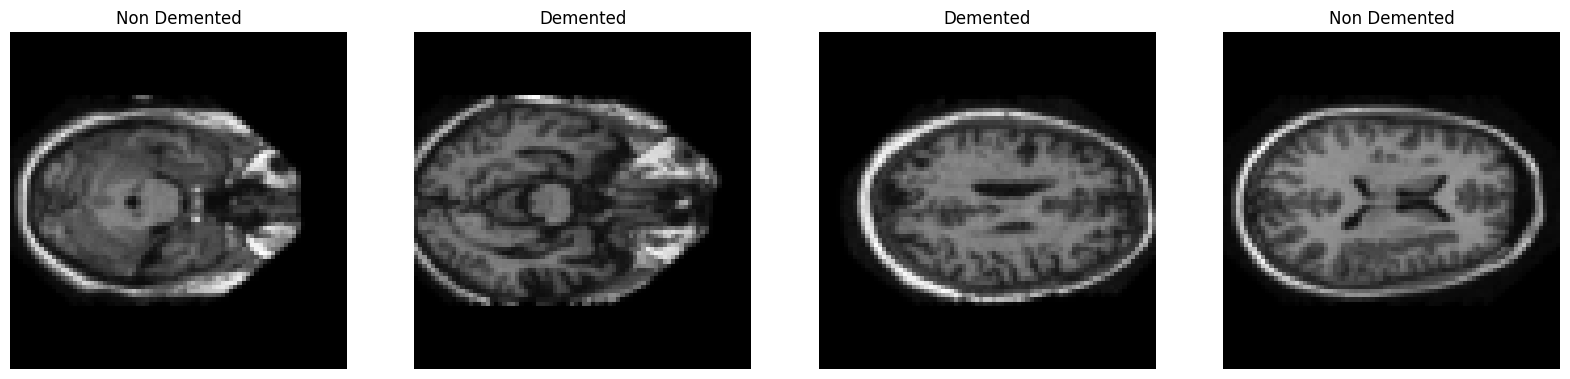

In [29]:
# Data loading and preprocessing
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
folders = {
    'demented': 1,
    'non_demented': 0
}

data = []
base_path = 'Aug_OASIS\Aug_OASIS'

# Collecting image file paths and labels
for folder, label in folders.items():
    folder_path = os.path.join(base_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):
            data.append({
                'file_path': os.path.join(folder_path, file),
                'label': label
            })

df = pd.DataFrame(data)

print(df.head(5))
print(df.shape)
print(df['label'].value_counts())

# Define the dataset class
class SimpleMRIDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['file_path']
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.long)
        return image, label
# Define transformations
transformations = transforms.Compose([
    transforms.Resize(50),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize((0.1266,), (0.1600,))  # Normalization 
])
# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
# Create datasets and DataLoader objects
train_dataset = SimpleMRIDataset(train_df, transform=transformations)
val_dataset = SimpleMRIDataset(val_df, transform=transformations)
test_dataset = SimpleMRIDataset(test_df, transform=transformations)
batch_size = 200
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Print the number of images in each dataset
print(f"Number of images in the training dataset: {len(train_dataset)}")
print(f"Number of images in the validation dataset: {len(val_dataset)}")
print(f"Number of images in the test dataset: {len(test_dataset)}")

def show_images_with_labels(loader, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    found_non_demented = 0
    found_demented = 0
    
    for images, labels in loader:
        for i, (image, label) in enumerate(zip(images, labels)):
            if (label == 0 and found_non_demented < num_images // 2) or (label == 1 and found_demented < num_images // 2):
                ax = axes[found_non_demented + found_demented]
                img = image.numpy()
                img = np.transpose(img, (1, 2, 0))
                ax.imshow(img * 0.1266 + 0.1600, cmap='gray')  # Unnormalize
                label_text = 'Non Demented' if label == 0 else 'Demented'
                ax.set_title(label_text)
                ax.axis('off')
                if label == 0:
                    found_non_demented += 1
                else:
                    found_demented += 1
            if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
                break
        if found_non_demented >= num_images // 2 and found_demented >= num_images // 2:
            break

show_images_with_labels(train_loader, 4)


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.7):  
        super(ModifiedResNet18, self).__init__()
        # Load a pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=True)

        # Replace the first convolutional layer
        # Original first layer: 64 output channels, kernel size 7, stride 2, padding 3
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)

        # Replace the final fully connected layer
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.resnet18(x)

num_classes = 2 
model = ModifiedResNet18(num_classes=num_classes)


c:\Users\Hursh Shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hursh Shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=30):
    device = torch.device("cuda:0")  # Directly set to use CUDA
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.01)

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time of the epoch

        model.train()
        total_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=total_loss/len(train_loader), accuracy=100.*correct/total)

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time
        print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")


        # Validation phase
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        val_loss /= len(val_loader)
        auc_score = roc_auc_score(all_labels, all_predictions)
        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader)}, Val Loss: {val_loss}, Val AUC: {auc_score}")


In [32]:
import dataclasses
from sklearn.metrics import roc_curve, auc

def evaluate_model(model, test_loader):
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    all_logits = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_logits.extend(outputs.cpu().numpy())

    all_logits = np.array(all_logits)
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

    # Metrics
    predicted_labels = np.argmax((all_logits > 0.5).astype(int), axis=1)  # Corrected syntax

    true_labels = np.array(all_labels)
    print(classification_report(true_labels, predicted_labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, all_logits[:,1])  # Update this for binary/multi-class
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
num_classes = 2  # Update this based on your specific problem (binary classification)
model = ModifiedResNet18(num_classes=num_classes, dropout_rate=0.7)  # Increased dropout rate
train_model(model, train_loader, val_loader, num_epochs=30)  # Reduced epochs
evaluate_model(model, test_loader) 
model = model.to('cuda')
data = data.to('cuda')

Training Epoch 1:  43%|████▎     | 234/538 [01:03<01:22,  3.70it/s, accuracy=86, loss=0.138]   


KeyboardInterrupt: 

In [ ]:
# Metrics
from sklearn.metrics import classification_report

# Assuming binary classification with logits as probabilities
predicted_labels = (all_logits > 0.5).astype(int)

# For binary classification with raw scores or multi-class classification
# predicted_labels = np.argmax(all_logits, axis=1)

true_labels = all_labels

print(classification_report(true_labels, predicted_labels))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

# Assuming you already have predicted_labels and true_labels from your previous code
conf_matrix = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(8, 6))  # Set the size of the figure

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', ax=ax)

# Labels, title, and ticks
label_font = {'size':'14'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Classical Transformer Confusion Matrix', fontdict={'size':16})  # Adjust to fit
ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit

# Save the figure
plt.savefig('trans_oasis_confusion_matrix.png')
plt.show()

import matplotlib.pyplot as plt

plt.figure()
plt.plot(test_fpr, test_tpr, color='darkorange', label='ROC curve (area = %0.4f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classical Transformer Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.savefig('trans_oasis_roc_curve.png')
plt.show()

NameError: name 'all_logits' is not defined